# Random Forest Rangers - Predicting Car Sales Prices
## Model Training and Prediction

In [207]:
# Install dependencies
!pip install -q -r requirements.txt

In [208]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing

In [209]:
dataset = pd.read_csv('./data/used_car_prices_preprocessed.csv')

print(dataset.dtypes)

model_year         int64
milage           float64
accident           int64
clean_title        int64
price            float64
turbo              int64
brand_encoded      int64
engine_score     float64
dtype: object


### Train Test Fold Split

In [210]:
from sklearn.model_selection import KFold

# Define the features and target variable
X = dataset.drop(columns=['price'])
y = dataset['price']

# Define the number of folds
k = 5

# Initialize KFold
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Perform cross-validation
for train_index, test_index in kf.split(X):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

print('X_train_fold shape:', X_train_fold.shape)
print('X_test_fold shape:', X_test_fold.shape)

X_train_fold shape: (3208, 7)
X_test_fold shape: (801, 7)


## Model Training
### Linear Regression

In [211]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

# Initialize the model
lr_model = LinearRegression()
scaler = StandardScaler()

# Data structure to store the results
benchmark_lr_models = []
best_lr_model = None

for train_index, test_index in kf.split(X):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    # Scale the data
    #X_train_fold_scaled = scaler.fit_transform(X_train_fold, y_train_fold)
    #X_test_fold_scaled = scaler.transform(X_test_fold)
    X_train_fold_scaled = pd.DataFrame(scaler.fit_transform(X_train_fold), columns=X_train_fold.columns)
    X_test_fold_scaled = pd.DataFrame(scaler.transform(X_test_fold), columns=X_test_fold.columns)

    # Train the model
    lr_model.fit(X_train_fold_scaled, y_train_fold)

    # Make predictions
    y_lr_pred = lr_model.predict(X_test_fold_scaled)

    # Calculate metrics
    lr_mse = mean_squared_error(y_test_fold, y_lr_pred)
    lr_r2 = r2_score(y_test_fold, y_lr_pred)

    benchmark_lr_models.append({
        'MSE': lr_mse,
        'R2': lr_r2
    })

    if not best_lr_model or lr_mse < best_lr_model['MSE']:
        best_lr_model = {
            'model': lr_model,
            'X_train': X_train_fold_scaled,
            'X_test': X_test_fold_scaled,
            'y_train': y_train_fold,
            'y_test': y_test_fold,
            'MSE': lr_mse,
            'R2': lr_r2
        }

# Convert results to DataFrame
benchmark_lr_models_df = pd.DataFrame(benchmark_lr_models)

# round mean values to 2 decimal places
print('Mean MSE :', round(benchmark_lr_models_df['MSE'].mean(), 2))
print('Mean R2:', round(benchmark_lr_models_df['R2'].mean(), 2))

print('Best model MSE:', round(best_lr_model['MSE'], 2))
print('Best model R2:', round(best_lr_model['R2'], 2))

Mean MSE : 5092958347.69
Mean R2: 0.31
Best model MSE: 1252753858.43
Best model R2: 0.41


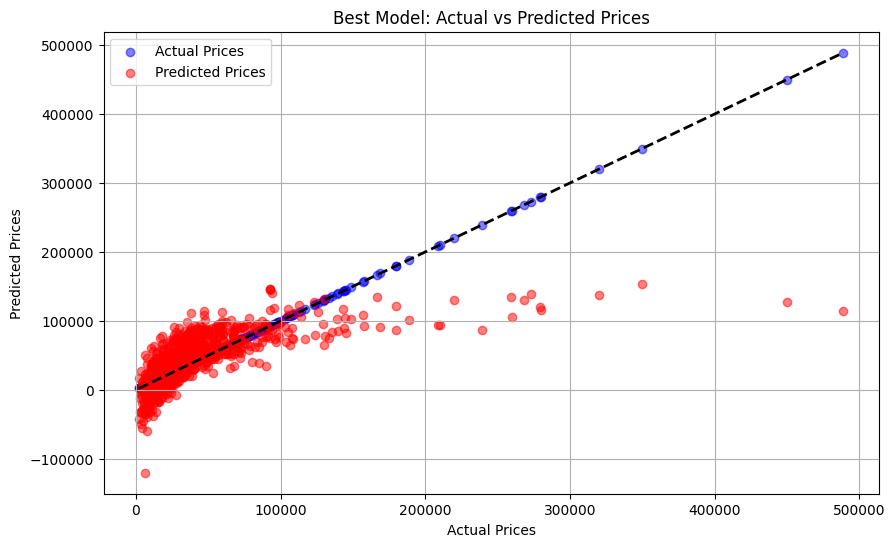

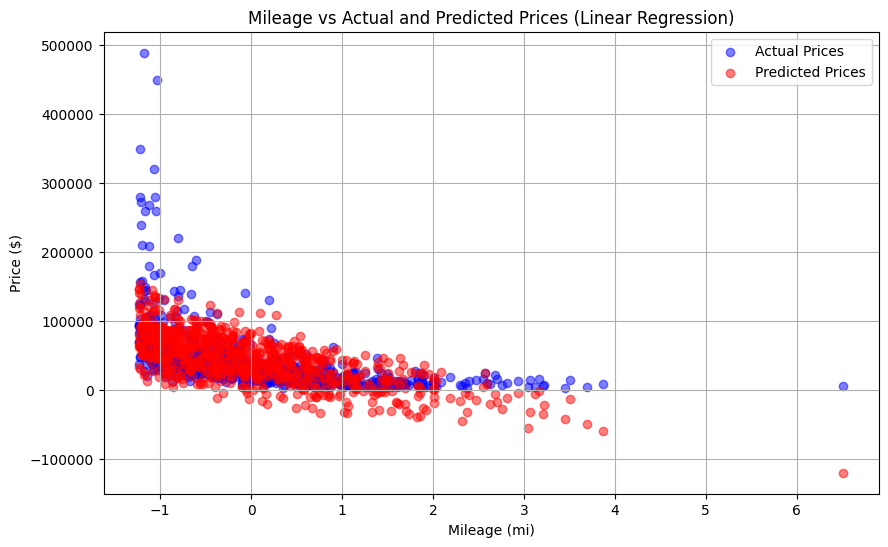

In [212]:
# Scatter plot for the best model
plt.figure(figsize=(10, 6))

# Plot actual test points
plt.scatter(best_lr_model['y_test'], best_lr_model['y_test'], color='blue', alpha=0.5, label='Actual Prices')

# Plot predicted points
plt.scatter(best_lr_model['y_test'], best_lr_model['model'].predict(best_lr_model['X_test']), color='red', alpha=0.5, label='Predicted Prices')

# Add a reference line
plt.plot([best_lr_model['y_test'].min(), best_lr_model['y_test'].max()], [best_lr_model['y_test'].min(), best_lr_model['y_test'].max()], 'k--', lw=2)

# Add a title and labels
plt.title('Best Model: Actual vs Predicted Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')

# Add a legend
plt.legend()

# Add a grid
plt.grid(True)

# Show the plot
plt.show()

# Scatter plot for mileage vs actual and predicted prices using the best linear regression model
plt.figure(figsize=(10, 6))

# Plot actual prices
plt.scatter(best_lr_model['X_test']['milage'], best_lr_model['y_test'], color='blue', alpha=0.5, label='Actual Prices')

# Plot predicted prices
plt.scatter(best_lr_model['X_test']['milage'], best_lr_model['model'].predict(best_lr_model['X_test']), color='red', alpha=0.5, label='Predicted Prices')

# Add a title and labels
plt.title('Mileage vs Actual and Predicted Prices (Linear Regression)')
plt.xlabel('Mileage (mi)')
plt.ylabel('Price ($)')

# Add a legend
plt.legend()

# Add a grid
plt.grid(True)

# Show the plot
plt.show()

### Polynomial Regression

In [213]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Define the degree of the polynomial
degree = 3

# Initialize the polynomial features transformer
poly = PolynomialFeatures(degree=degree)

# Initialize the model
poly_model = LinearRegression()

# Data structure to store the results
benchmark_poly_models = []
best_poly_model = None

for train_index, test_index in kf.split(X):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    # Transform the features to polynomial features
    X_train_poly = poly.fit_transform(X_train_fold)
    X_test_poly = poly.transform(X_test_fold)

    # Train the model
    poly_model.fit(X_train_poly, y_train_fold)

    # Make predictions
    y_poly_pred = poly_model.predict(X_test_poly)

    # Calculate metrics
    poly_mse = mean_squared_error(y_test_fold, y_poly_pred)
    poly_r2 = r2_score(y_test_fold, y_poly_pred)

    benchmark_poly_models.append({
        'MSE': poly_mse,
        'R2': poly_r2
    })

    if not best_poly_model or poly_mse < best_poly_model['MSE']:
        best_poly_model = {
            'model': poly_model,
            'X_train': X_train_fold,
            'X_test': X_test_fold,
            'y_train': y_train_fold,
            'y_test': y_test_fold,
            'MSE': poly_mse,
            'R2': poly_r2
        }

# Convert results to DataFrame
benchmark_poly_models_df = pd.DataFrame(benchmark_poly_models)

# round mean values to 2 decimal places
print('Mean MSE :', round(benchmark_poly_models_df['MSE'].mean(), 2))
print('Mean R2:', round(benchmark_poly_models_df['R2'].mean(), 2))

print('Best model MSE:', round(best_poly_model['MSE'], 2))
print('Best model R2:', round(best_poly_model['R2'], 2))

Mean MSE : 5249934249.42
Mean R2: 0.11
Best model MSE: 1260845239.31
Best model R2: 0.42


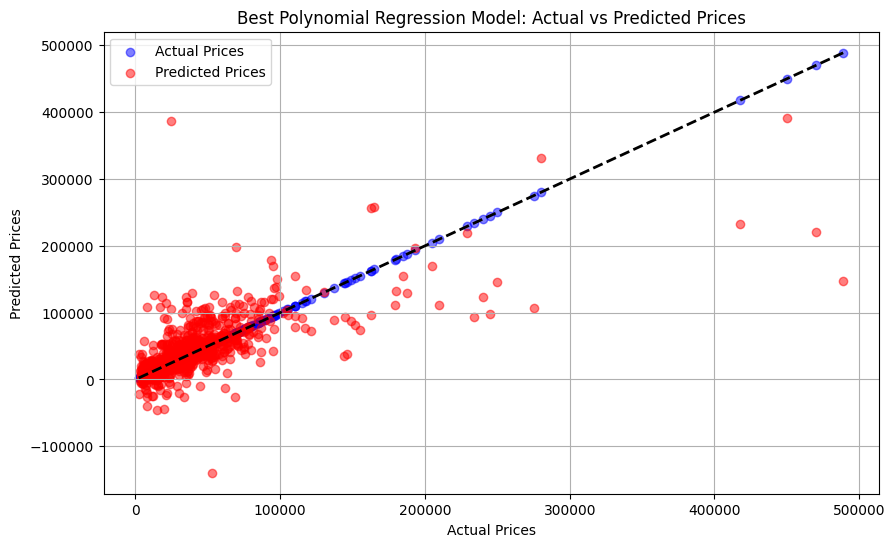

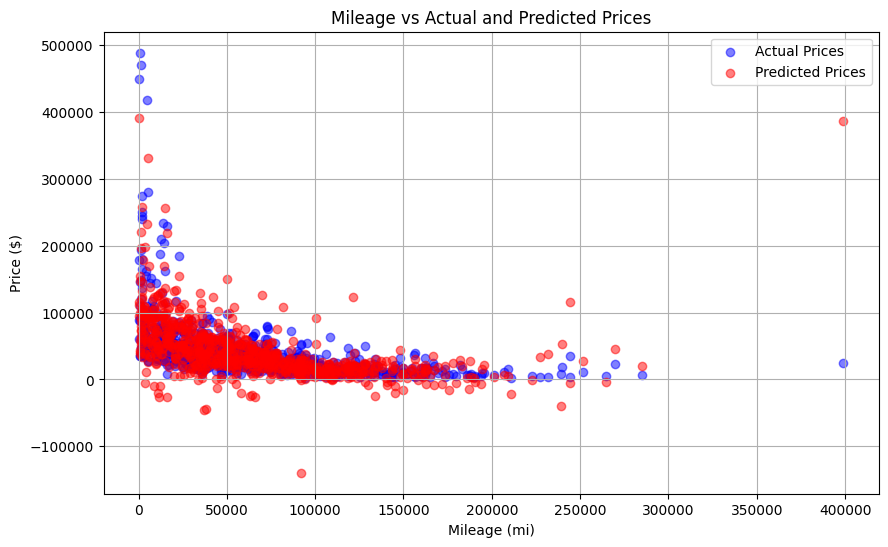

In [214]:
# Scatter plot for the best polynomial regression model
plt.figure(figsize=(10, 6))

# Plot actual test points
plt.scatter(best_poly_model['y_test'], best_poly_model['y_test'], color='blue', alpha=0.5, label='Actual Prices')

# Plot predicted points
plt.scatter(best_poly_model['y_test'], best_poly_model['model'].predict(poly.transform(best_poly_model['X_test'])), color='red', alpha=0.5, label='Predicted Prices')

# Add a reference line
plt.plot([best_poly_model['y_test'].min(), best_poly_model['y_test'].max()], [best_poly_model['y_test'].min(), best_poly_model['y_test'].max()], 'k--', lw=2)

# Add a title and labels
plt.title('Best Polynomial Regression Model: Actual vs Predicted Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')

# Add a legend
plt.legend()

# Add a grid
plt.grid(True)

# Show the plot
plt.show()

# Scatter plot for mileage vs actual and predicted prices using the best polynomial regression model
plt.figure(figsize=(10, 6))

# Plot actual prices
plt.scatter(best_poly_model['X_test']['milage'], best_poly_model['y_test'], color='blue', alpha=0.5, label='Actual Prices')

# Plot predicted prices
plt.scatter(best_poly_model['X_test']['milage'], best_poly_model['model'].predict(poly.transform(best_poly_model['X_test'])), color='red', alpha=0.5, label='Predicted Prices')

# Add a title and labels
plt.title('Mileage vs Actual and Predicted Prices')
plt.xlabel('Mileage (mi)')
plt.ylabel('Price ($)')

# Add a legend
plt.legend()

# Add a grid
plt.grid(True)

# Show the plot
plt.show()

### Random Forest Regressor

In [215]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Data structure to store the results
benchmark_rf_models = []
best_rf_model = None

for train_index, test_index in kf.split(X):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    # Train the model
    rf_model.fit(X_train_fold, y_train_fold)

    # Make predictions
    y_rf_pred = rf_model.predict(X_test_fold)

    # Calculate metrics
    rf_mse = mean_squared_error(y_test_fold, y_rf_pred)
    rf_r2 = r2_score(y_test_fold, y_rf_pred)

    benchmark_rf_models.append({
        'MSE': rf_mse,
        'R2': rf_r2
    })

    if not best_rf_model or rf_mse < best_rf_model['MSE']:
        best_rf_model = {
            'model': rf_model,
            'X_train': X_train_fold,
            'X_test': X_test_fold,
            'y_train': y_train_fold,
            'y_test': y_test_fold,
            'MSE': rf_mse,
            'R2': rf_r2
        }

# Convert results to DataFrame
benchmark_rf_models_df = pd.DataFrame(benchmark_rf_models)

# round mean values to 2 decimal places
print('Mean MSE :', round(benchmark_rf_models_df['MSE'].mean(), 2))
print('Mean R2:', round(benchmark_rf_models_df['R2'].mean(), 2))

print('Best model MSE:', round(best_rf_model['MSE'], 2))
print('Best model R2:', round(best_rf_model['R2'], 2))


Mean MSE : 6211794284.11
Mean R2: -0.43
Best model MSE: 721768085.72
Best model R2: 0.67


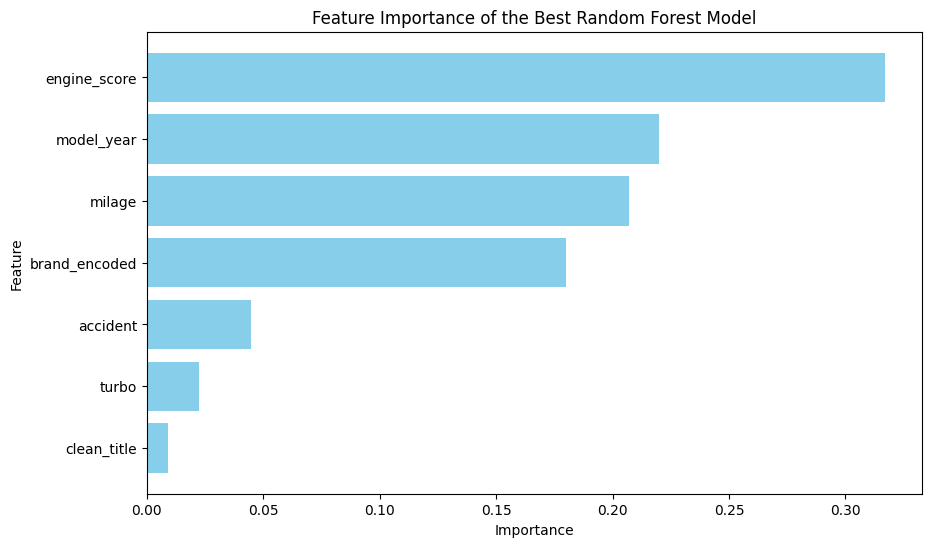

In [216]:
# Get feature importance
rf_feature_importance = best_rf_model['model'].feature_importances_

# Get feature names
rf_feature_names = X.columns

# Create a DataFrame for better visualization
rf_importance_df = pd.DataFrame({
    'Feature': rf_feature_names,
    'Importance': rf_feature_importance
})

# Sort the DataFrame by importance
rf_importance_df = rf_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(rf_importance_df['Feature'], rf_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance of the Best Random Forest Model')
plt.gca().invert_yaxis()
plt.show()

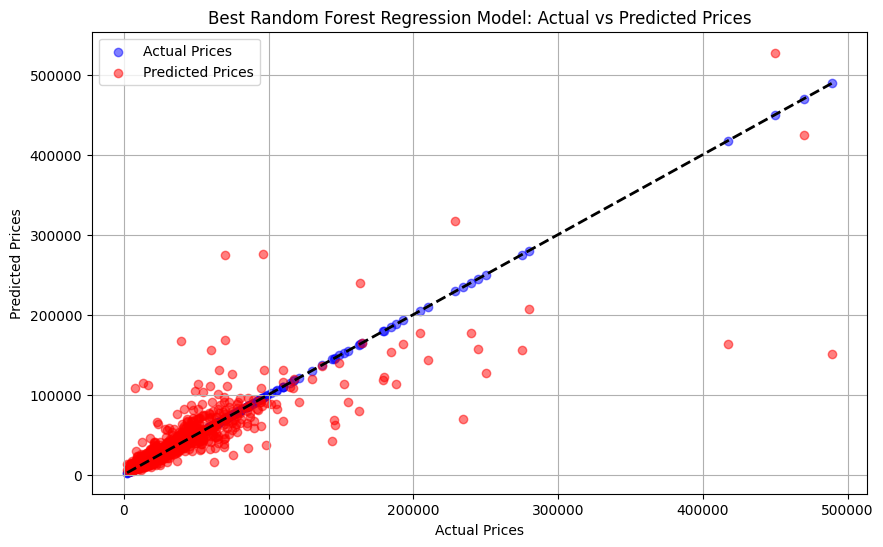

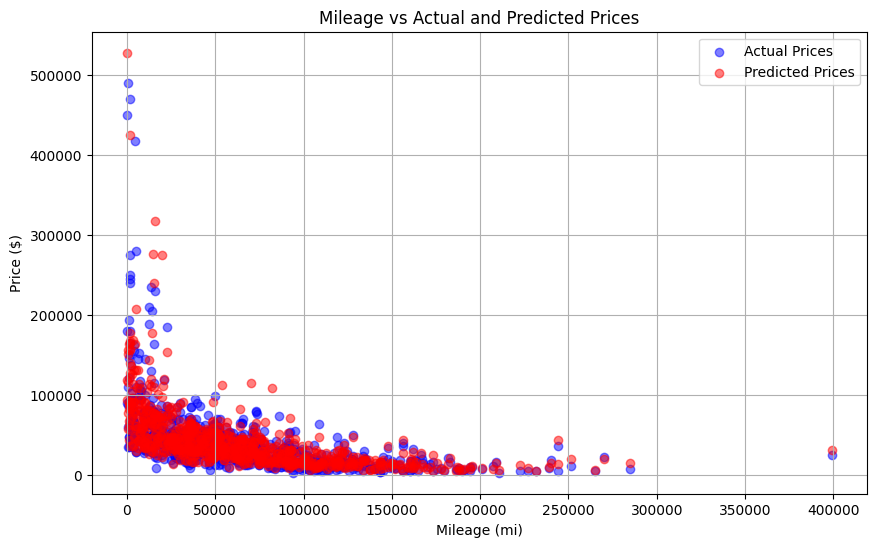

In [217]:
# Scatter plot for the best Random Forest regression model
plt.figure(figsize=(10, 6))

# Plot actual test points
plt.scatter(best_rf_model['y_test'], best_rf_model['y_test'], color='blue', alpha=0.5, label='Actual Prices')

# Plot predicted points
plt.scatter(best_rf_model['y_test'], best_rf_model['model'].predict(best_rf_model['X_test']), color='red', alpha=0.5, label='Predicted Prices')

# Add a reference line
plt.plot([best_rf_model['y_test'].min(), best_rf_model['y_test'].max()], [best_rf_model['y_test'].min(), best_rf_model['y_test'].max()], 'k--', lw=2)

# Add a title and labels
plt.title('Best Random Forest Regression Model: Actual vs Predicted Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')

# plt.xlim(0, 80000)
# plt.ylim(0, 80000)

# Add a legend
plt.legend()

# Add a grid
plt.grid(True)

# Show the plot
plt.show()

# Scatter plot for mileage vs actual and predicted prices using the best Random Forest regression model
plt.figure(figsize=(10, 6))

# Plot actual prices
plt.scatter(best_rf_model['X_test']['milage'], best_rf_model['y_test'], color='blue', alpha=0.5, label='Actual Prices')

# Plot predicted prices
plt.scatter(best_rf_model['X_test']['milage'], best_rf_model['model'].predict(best_rf_model['X_test']), color='red', alpha=0.5, label='Predicted Prices')

# Add a title and labels
plt.title('Mileage vs Actual and Predicted Prices')
plt.xlabel('Mileage (mi)')
plt.ylabel('Price ($)')

# Add a legend
plt.legend()

# Add a grid
plt.grid(True)

# Show the plot
plt.show()

In [218]:
from xgboost import XGBRegressor

# Initialize the model
xgb_model = XGBRegressor(n_estimators=100, random_state=42)

# Data structure to store the results
benchmark_xgb_models = []
best_xgb_model = None

for train_index, test_index in kf.split(X):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    # Train the model
    xgb_model.fit(X_train_fold, y_train_fold)

    # Make predictions
    y_xgb_pred = xgb_model.predict(X_test_fold)

    # Calculate metrics
    xgb_mse = mean_squared_error(y_test_fold, y_xgb_pred)
    xgb_r2 = r2_score(y_test_fold, y_xgb_pred)

    benchmark_xgb_models.append({
        'MSE': xgb_mse,
        'R2': xgb_r2
    })

    if not best_xgb_model or xgb_mse < best_xgb_model['MSE']:
        best_xgb_model = {
            'model': xgb_model,
            'X_train': X_train_fold,
            'X_test': X_test_fold,
            'y_train': y_train_fold,
            'y_test': y_test_fold,
            'MSE': xgb_mse,
            'R2': xgb_r2
        }

# Convert results to DataFrame
benchmark_xgb_models_df = pd.DataFrame(benchmark_xgb_models)

# round mean values to 2 decimal places
print('Mean MSE :', round(benchmark_xgb_models_df['MSE'].mean(), 2))
print('Mean R2:', round(benchmark_xgb_models_df['R2'].mean(), 2))

print('Best model MSE:', round(best_xgb_model['MSE'], 2))
print('Best model R2:', round(best_xgb_model['R2'], 2))


Mean MSE : 11511866225.54
Mean R2: -2.92
Best model MSE: 599176123.45
Best model R2: 0.72


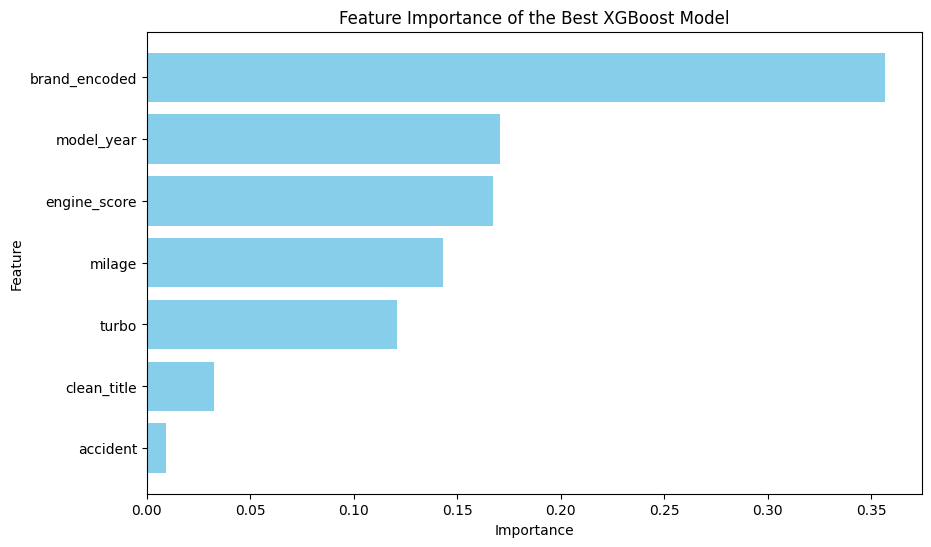

In [219]:
# Get feature importance
feature_importance = best_xgb_model['model'].feature_importances_

# Get feature names
feature_names = X.columns

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance of the Best XGBoost Model')
plt.gca().invert_yaxis()
plt.show()

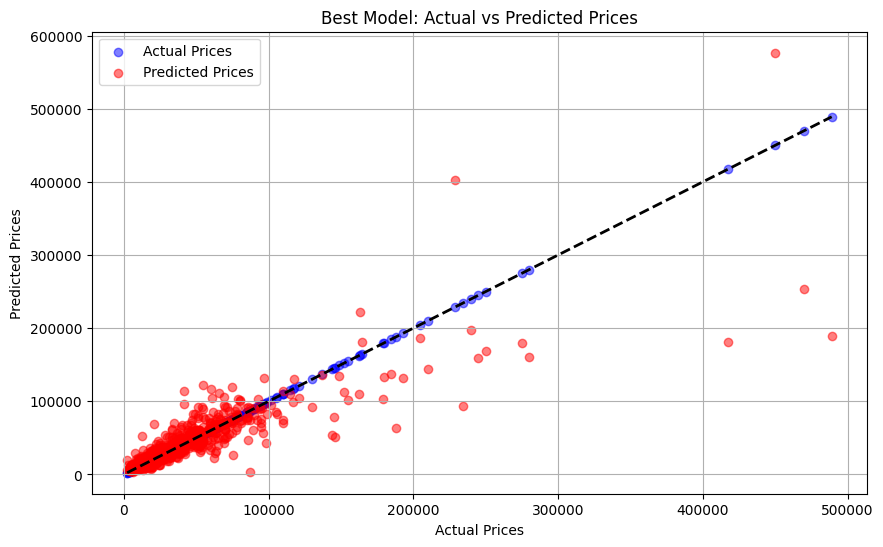

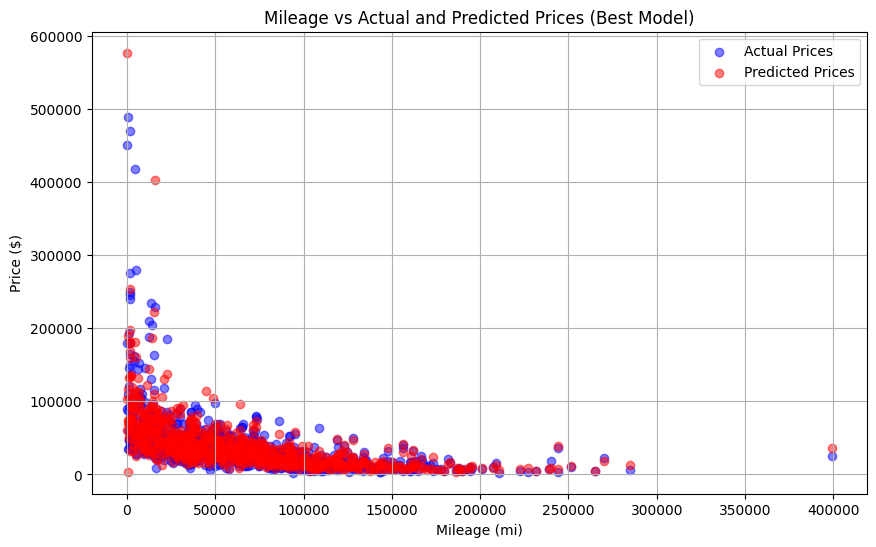

In [220]:
# Scatter plot for the best model
plt.figure(figsize=(10, 6))

# Plot actual test points
plt.scatter(best_xgb_model['y_test'], best_xgb_model['y_test'], color='blue', alpha=0.5, label='Actual Prices')

# Plot predicted points
plt.scatter(best_xgb_model['y_test'], best_xgb_model['model'].predict(best_xgb_model['X_test']), color='red', alpha=0.5, label='Predicted Prices')

# Add a reference line
plt.plot([best_xgb_model['y_test'].min(), best_xgb_model['y_test'].max()], [best_xgb_model['y_test'].min(), best_xgb_model['y_test'].max()], 'k--', lw=2)

# Add a title and labels
plt.title('Best Model: Actual vs Predicted Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')

# Add a legend
plt.legend()

# Add a grid
plt.grid(True)

# Show the plot
plt.show()

# Scatter plot for mileage vs actual and predicted prices using the best model
plt.figure(figsize=(10, 6))

# Plot actual prices
plt.scatter(best_xgb_model['X_test']['milage'], best_xgb_model['y_test'], color='blue', alpha=0.5, label='Actual Prices')

# Plot predicted prices
plt.scatter(best_xgb_model['X_test']['milage'], best_xgb_model['model'].predict(best_xgb_model['X_test']), color='red', alpha=0.5, label='Predicted Prices')

# Add a title and labels
plt.title('Mileage vs Actual and Predicted Prices (Best Model)')
plt.xlabel('Mileage (mi)')
plt.ylabel('Price ($)')

# Add a legend
plt.legend()

# Add a grid
plt.grid(True)

# Show the plot
plt.show()

### LGBM Regressor

In [221]:
import lightgbm as ltb

# Initialize the model
lgbm_model = ltb.LGBMRegressor(verbosity=-1, n_estimators=100, random_state=42)

# Data structure to store the results
benchmark_lgbm_models = []
best_lgbm_model = None

for train_index, test_index in kf.split(X):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    # Train the model
    lgbm_model.fit(X_train_fold, y_train_fold)

    # Make predictions
    y_lgbm_pred = lgbm_model.predict(X_test_fold)

    # Calculate metrics
    lgbm_mse = mean_squared_error(y_test_fold, y_lgbm_pred)
    lgbm_r2 = r2_score(y_test_fold, y_lgbm_pred)

    benchmark_lgbm_models.append({
        'MSE': lgbm_mse,
        'R2': lgbm_r2
    })

    if not best_lgbm_model or lgbm_mse < best_lgbm_model['MSE']:
        best_lgbm_model = {
            'model': lgbm_model,
            'X_train': X_train_fold,
            'X_test': X_test_fold,
            'y_train': y_train_fold,
            'y_test': y_test_fold,
            'MSE': lgbm_mse,
            'R2': lgbm_r2
        }

# Convert results to DataFrame
benchmark_lgbm_models_df = pd.DataFrame(benchmark_lgbm_models)

# round mean values to 2 decimal places
print('Mean MSE :', round(benchmark_lgbm_models_df['MSE'].mean(), 2))
print('Mean R2:', round(benchmark_lgbm_models_df['R2'].mean(), 2))

print('Best model MSE:', round(best_lgbm_model['MSE'], 2))
print('Best model R2:', round(best_lgbm_model['R2'], 2))

Mean MSE : 4477539835.01
Mean R2: 0.37
Best model MSE: 816668836.32
Best model R2: 0.62


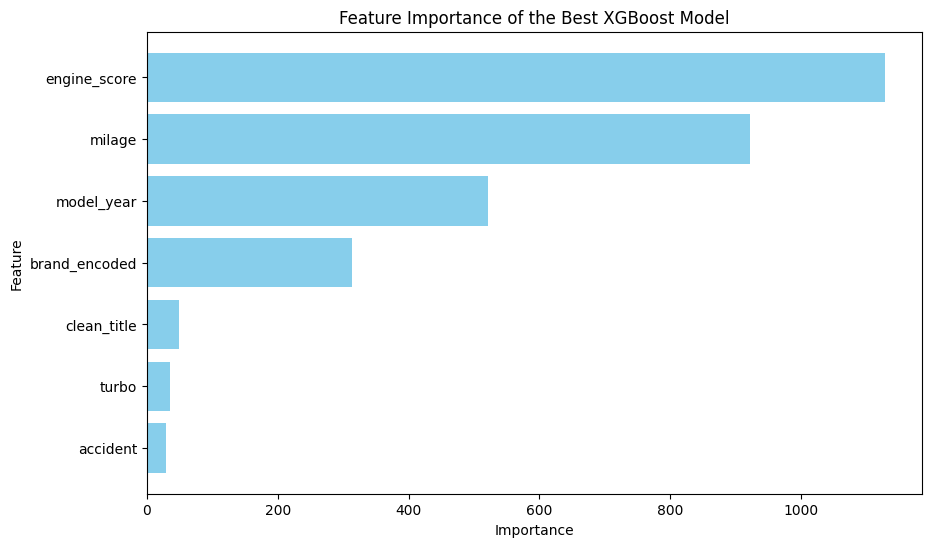

In [222]:
# Get feature importance
feature_importance = best_lgbm_model['model'].feature_importances_

# Get feature names
feature_names = X.columns

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance of the Best XGBoost Model')
plt.gca().invert_yaxis()
plt.show()